# **1. Data Loading and Preprocessing**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the datasets
train_df = pd.read_excel('/content/HAR_train_dataset.xlsx')
test_df = pd.read_excel('/content/HAR_test_dataset.xlsx')

# Check for missing values
train_missing = train_df.isnull().sum()
test_missing = test_df.isnull().sum()

# Fill missing values (if any)
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

# Convert activity column to categorical
train_df['activity'] = train_df['activity'].astype('category')
test_df['activity'] = test_df['activity'].astype('category')

# Map activity labels to integers
activity_map = {label: idx for idx, label in enumerate(train_df['activity'].cat.categories)}
train_df['activity'] = train_df['activity'].map(activity_map)
test_df['activity'] = test_df['activity'].map(activity_map)

# Split the data into features (X) and labels (y)
X_train = train_df.drop(['subject', 'activity'], axis=1)
y_train = train_df['activity']
X_test = test_df.drop(['subject', 'activity'], axis=1)
y_test = test_df['activity']

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **2. Experimenting with Feature Selection and Cross-Validation**

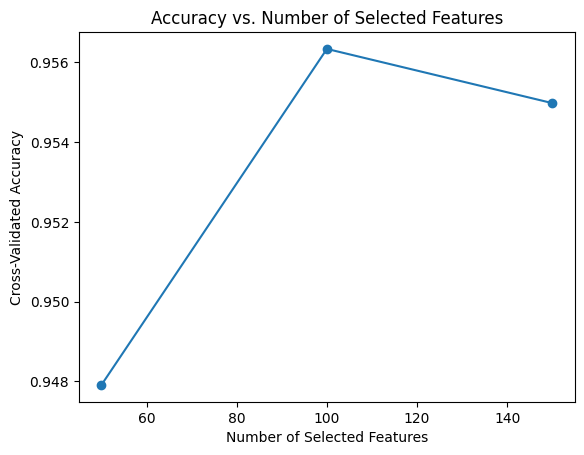

In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

lr_model = LogisticRegression(max_iter=1000)

# Try different numbers of selected features (e.g., 10, 20, 50, 100)
num_features = [50,100,150]
mean_accuracies = []

# Loop through different feature selections
for n in num_features:
    selector = RFE(estimator=lr_model, n_features_to_select=n, step=2)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)

    # Evaluate using cross-validation
    accuracy = cross_val_score(lr_model, X_train_selected, y_train, cv=3, scoring='accuracy').mean()
    mean_accuracies.append(accuracy)

# Plot results
plt.plot(num_features, mean_accuracies, marker='o')
plt.title('Accuracy vs. Number of Selected Features')
plt.xlabel('Number of Selected Features')
plt.ylabel('Cross-Validated Accuracy')
plt.show()


# **3.Feature Selection using RFE (Recursive Feature Elimination)**

In [2]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression Model for RFE
lr_model = LogisticRegression(max_iter=1000)

# Apply RFE for feature selection (select top 100 features)
rfe_selector = RFE(estimator=lr_model, n_features_to_select=100, step=2)
X_train_selected = rfe_selector.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe_selector.transform(X_test_scaled)

# Get the selected feature names
selected_feature_names = X_train.columns[rfe_selector.support_]
print(f"Selected Features (RFE): {selected_feature_names}")


Selected Features (RFE): Index(['tBodyAcc-mean()-Y', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Z',
       'tBodyAcc-min()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y',
       'tBodyAcc-arCoeff()-X,4', 'tBodyAcc-arCoeff()-Y,4',
       'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-Y,Z',
       'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-std()-Y',
       'tGravityAcc-mad()-Z', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y',
       'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-sma()',
       'tGravityAcc-energy()-X', 'tGravityAcc-energy()-Y',
       'tGravityAcc-energy()-Z', 'tGravityAcc-entropy()-X',
       'tGravityAcc-entropy()-Y', 'tGravityAcc-arCoeff()-X,1',
       'tGravityAcc-arCoeff()-Y,1', 'tGravityAcc-arCoeff()-Y,4',
       'tBodyAccJerk-max()-X', 'tBodyAccJerk-max()-Y', 'tBodyAccJerk-max()-Z',
       'tBodyAccJerk-min()-X', 'tBodyAccJerk-min()-Y', 'tBodyAccJerk-iqr()-Y',
       'tBodyAccJerk-entropy()-X', 'tBodyAccJerk-entropy()-Z',
       'tB

# **4. Define and Train SVM with Custom Kernel**

In [3]:
from sklearn.svm import SVC

# Custom kernel function (Gaussian-like kernel)
def custom_kernel(X, Y, gamma=0.1):
    """
    A custom kernel that computes the similarity between two feature vectors.
    Example: Gaussian (RBF) kernel-like function with a custom parameter.

    X, Y: input feature matrices (each row is a sample)
    gamma: the parameter for the Gaussian kernel

    Returns: a kernel matrix where element (i, j) is the similarity between X[i] and Y[j].
    """
    X_norm_sq = np.sum(X**2, axis=1, keepdims=True)
    Y_norm_sq = np.sum(Y**2, axis=1, keepdims=True).T
    pairwise_dist_sq = X_norm_sq + Y_norm_sq - 2 * np.dot(X, Y.T)
    pairwise_dist_sq[pairwise_dist_sq < 0] = 0
    return np.exp(-gamma * pairwise_dist_sq)  # Apply Gaussian kernel function

# Assuming best_gamma and best_C are available from the previous tuning step
best_gamma = 0.001
best_C = 1000

# Compute the training and testing kernel matrices using the best_gamma
K_train = custom_kernel(X_train_selected, X_train_selected, gamma=best_gamma)
K_test = custom_kernel(X_test_selected, X_train_selected, gamma=best_gamma)

# Initialize SVM model with precomputed kernel and best_C
svm_model_custom_kernel_precomputed = SVC(kernel='precomputed', C=best_C, random_state=42, probability=True)

# Train the custom kernel SVM model
svm_model_custom_kernel_precomputed.fit(K_train, y_train)


SVC(C=1000, kernel='precomputed', probability=True, random_state=42)

# **5.Train Models**

In [4]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier

# Initialize models
svm_model_rbf = SVC(kernel='rbf', C=8.162547295007347, random_state=42, probability=True, gamma='scale')
svm_model_linear = SVC(kernel='linear', C=8.162547295007347, random_state=42, probability=True)
svm_model_poly = SVC(kernel='poly', degree=3, C=8.162547295007347, random_state=42, probability=True)


# Use the best hyperparameters found for the Random Forest model
best_params_rf = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params_rf)


lr_model = LogisticRegression(max_iter=1000)
ann_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Define Voting Classifier (Soft Voting) - Removed custom kernel SVM
voting_model = VotingClassifier(estimators=[('rf', rf_model), ('svm_rbf', svm_model_rbf), ('lr', lr_model)], voting='soft')

# Define Stacking Classifier - Removed custom kernel SVM
stacking_model = StackingClassifier(estimators=[('rf', rf_model), ('svm_rbf', svm_model_rbf), ('ann', ann_model)], final_estimator=LogisticRegression())


# Train individual models
models_to_train = {
    'SVM (Custom Kernel)': svm_model_custom_kernel_precomputed,
    'SVM (RBF Kernel)': svm_model_rbf,
    'SVM (Linear Kernel)': svm_model_linear,
    'SVM (Polynomial Kernel)': svm_model_poly,
    'Random Forest': rf_model,
    'Logistic Regression': lr_model,
    'ANN': ann_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model,
    'Voting Classifier': voting_model,
    'Stacking Classifier': stacking_model
}

trained_models = {}
for name, model in models_to_train.items():
    print(f"Training {name} model...")
    if name == 'SVM (Custom Kernel)':
        model.fit(K_train, y_train)
    else:
        model.fit(X_train_selected, y_train)
    trained_models[name] = model

Training SVM (Custom Kernel) model...
Training SVM (RBF Kernel) model...
Training SVM (Linear Kernel) model...
Training SVM (Polynomial Kernel) model...
Training Random Forest model...
Training Logistic Regression model...
Training ANN model...
Training XGBoost model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:12:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25269
[LightGBM] [Info] Number of data points in the train set: 7352, number of used features: 100
[LightGBM] [Info] Start training from score -1.653513
[LightGBM] [Info] Start training from score -1.743436
[LightGBM] [Info] Start training from score -1.677246
[LightGBM] [Info] Start training from score -1.791216
[LightGBM] [Info] Start training from score -2.009071
[LightGBM] [Info] Start training from score -1.924514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

# **6.Evaluate Models**

Evaluating SVM (Custom Kernel) model...
SVM (Custom Kernel) - Train Accuracy: 0.9985
SVM (Custom Kernel) - Test Accuracy: 0.9586


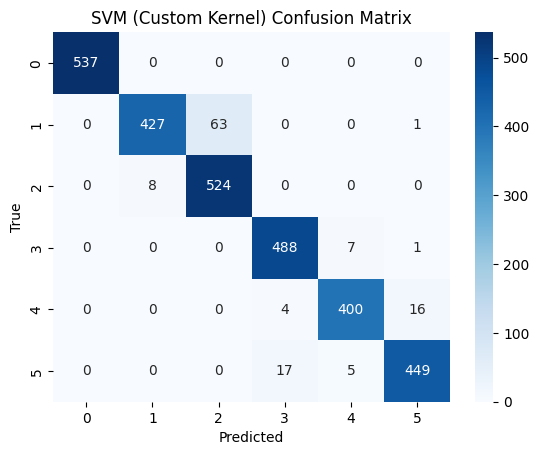

SVM (Custom Kernel) - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.98      0.87      0.92       491
           2       0.89      0.98      0.94       532
           3       0.96      0.98      0.97       496
           4       0.97      0.95      0.96       420
           5       0.96      0.95      0.96       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



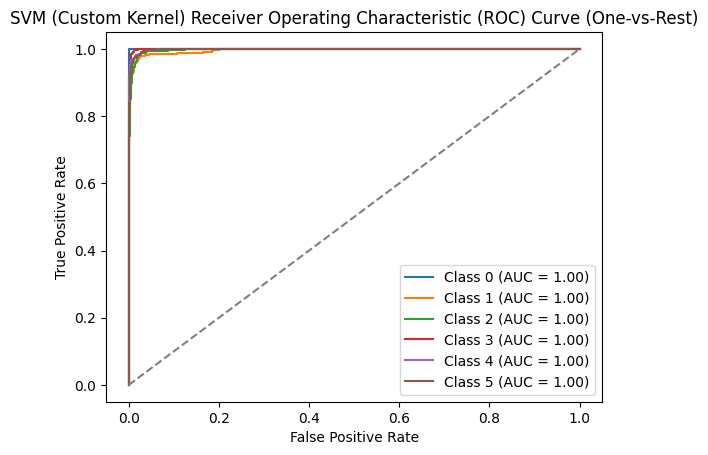

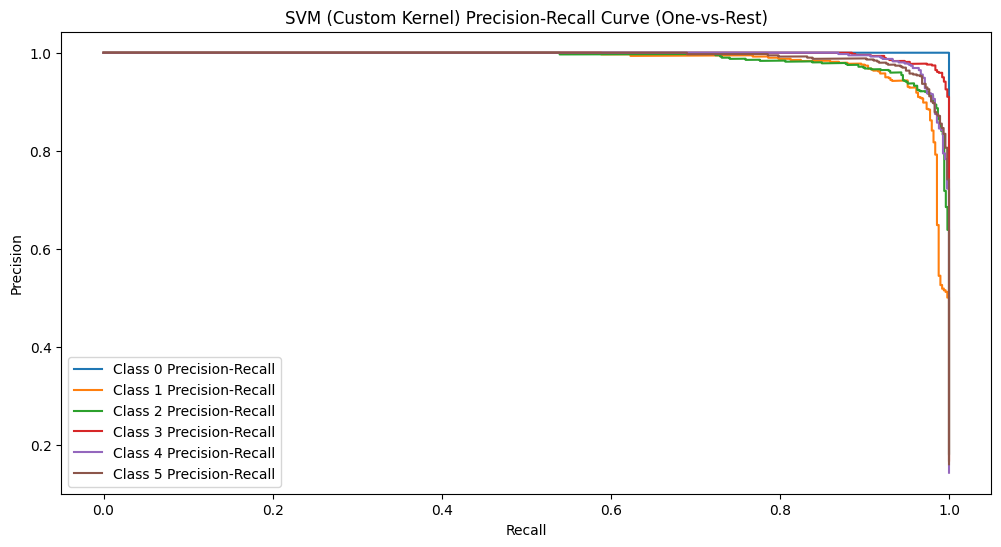

Evaluating SVM (RBF Kernel) model...
SVM (RBF Kernel) - Train Accuracy: 0.9980
SVM (RBF Kernel) - Test Accuracy: 0.9532


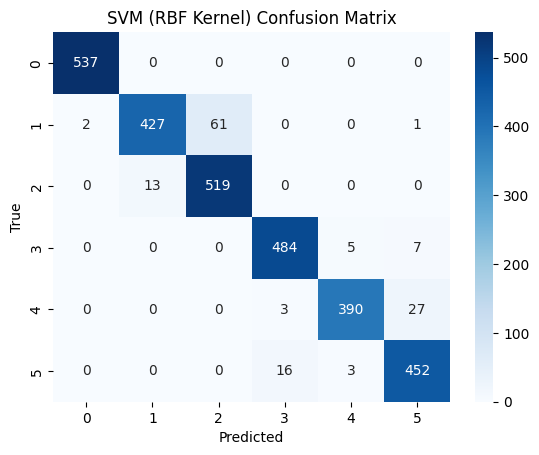

SVM (RBF Kernel) - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.97      0.87      0.92       491
           2       0.89      0.98      0.93       532
           3       0.96      0.98      0.97       496
           4       0.98      0.93      0.95       420
           5       0.93      0.96      0.94       471

    accuracy                           0.95      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



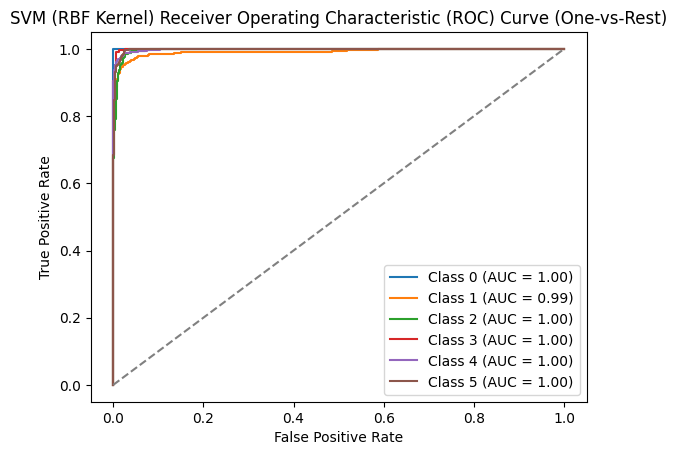

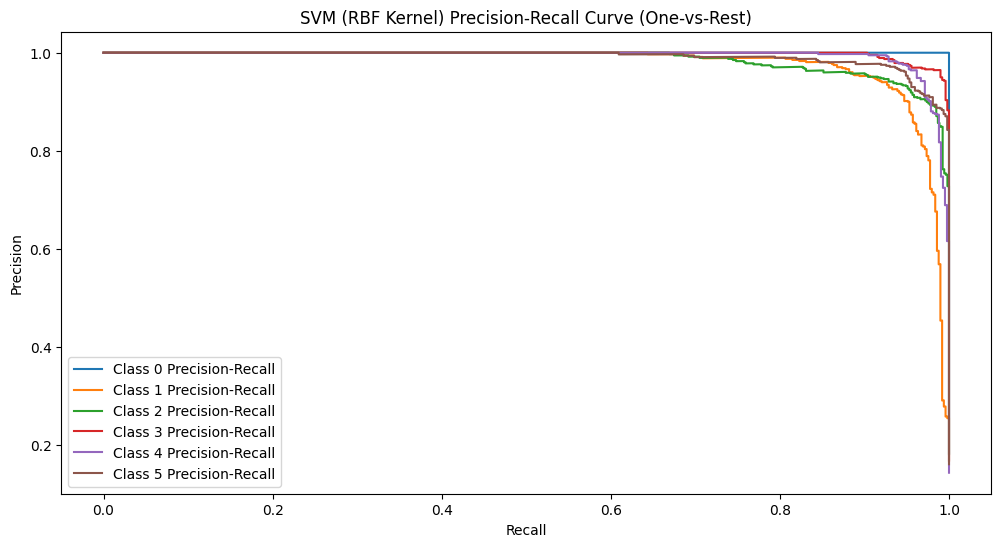

Evaluating SVM (Linear Kernel) model...
SVM (Linear Kernel) - Train Accuracy: 0.9928
SVM (Linear Kernel) - Test Accuracy: 0.9596


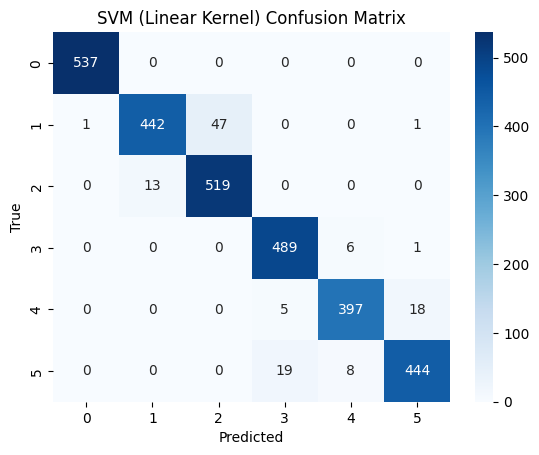

SVM (Linear Kernel) - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.97      0.90      0.93       491
           2       0.92      0.98      0.95       532
           3       0.95      0.99      0.97       496
           4       0.97      0.95      0.96       420
           5       0.96      0.94      0.95       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



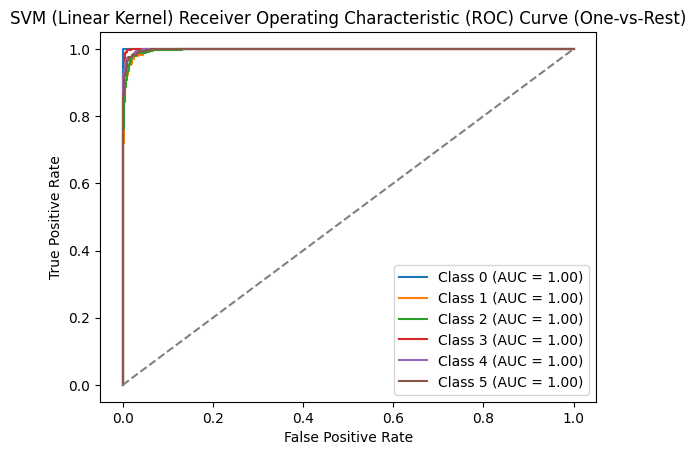

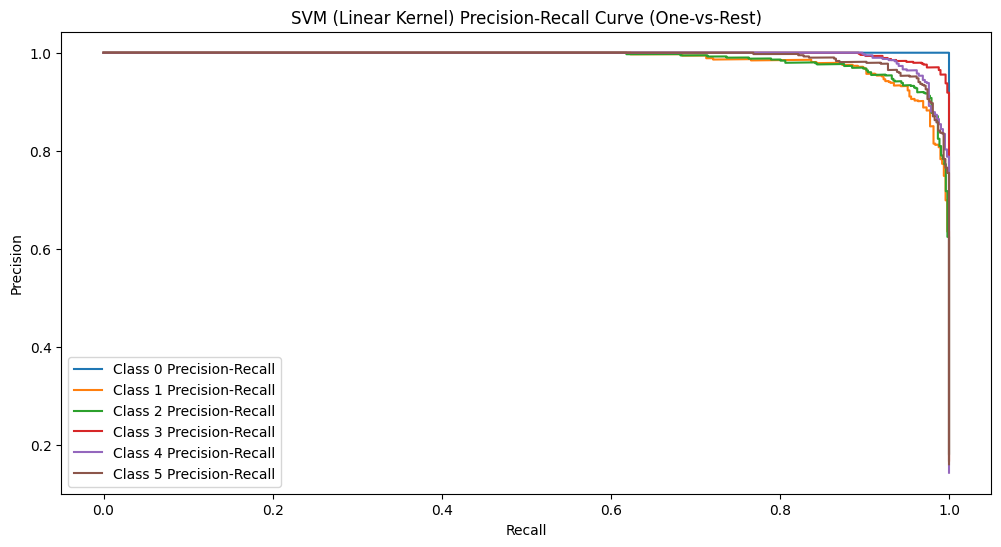

Evaluating SVM (Polynomial Kernel) model...
SVM (Polynomial Kernel) - Train Accuracy: 0.9976
SVM (Polynomial Kernel) - Test Accuracy: 0.9508


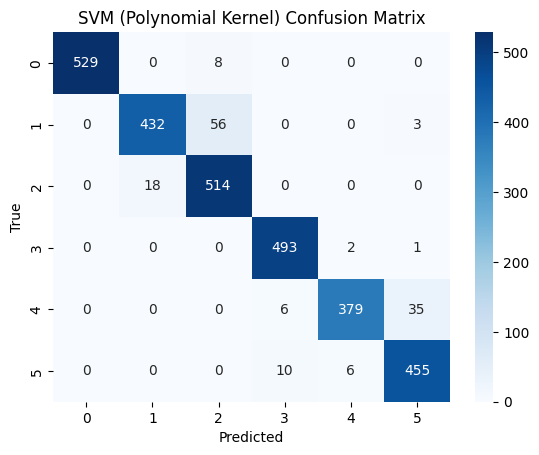

SVM (Polynomial Kernel) - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       537
           1       0.96      0.88      0.92       491
           2       0.89      0.97      0.93       532
           3       0.97      0.99      0.98       496
           4       0.98      0.90      0.94       420
           5       0.92      0.97      0.94       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



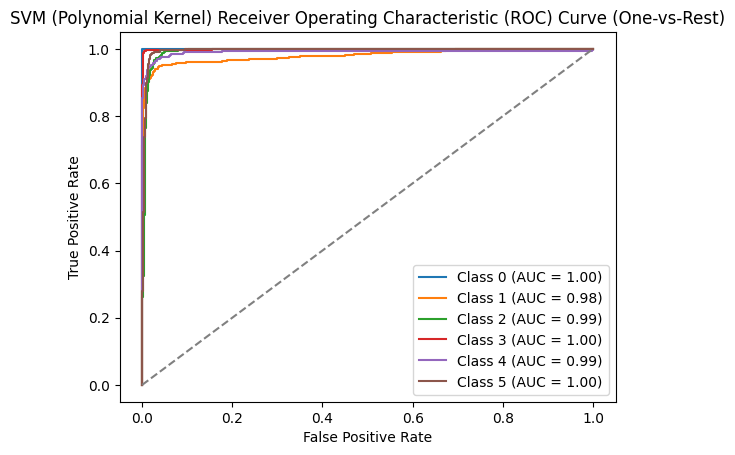

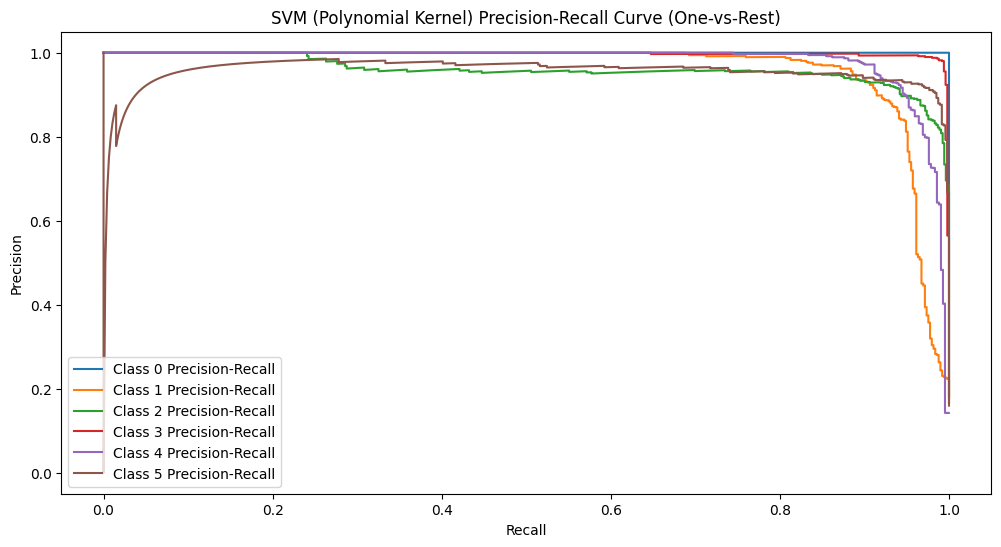

Evaluating Random Forest model...
Random Forest - Train Accuracy: 0.9996
Random Forest - Test Accuracy: 0.8968


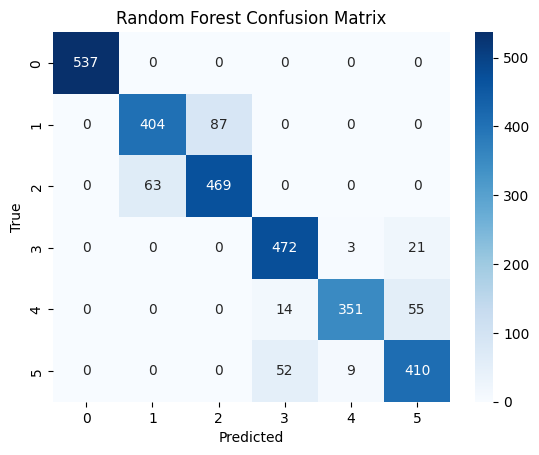

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.87      0.82      0.84       491
           2       0.84      0.88      0.86       532
           3       0.88      0.95      0.91       496
           4       0.97      0.84      0.90       420
           5       0.84      0.87      0.86       471

    accuracy                           0.90      2947
   macro avg       0.90      0.89      0.90      2947
weighted avg       0.90      0.90      0.90      2947



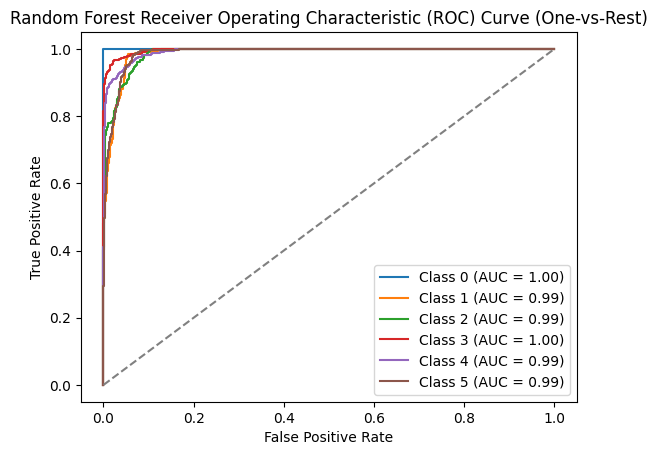

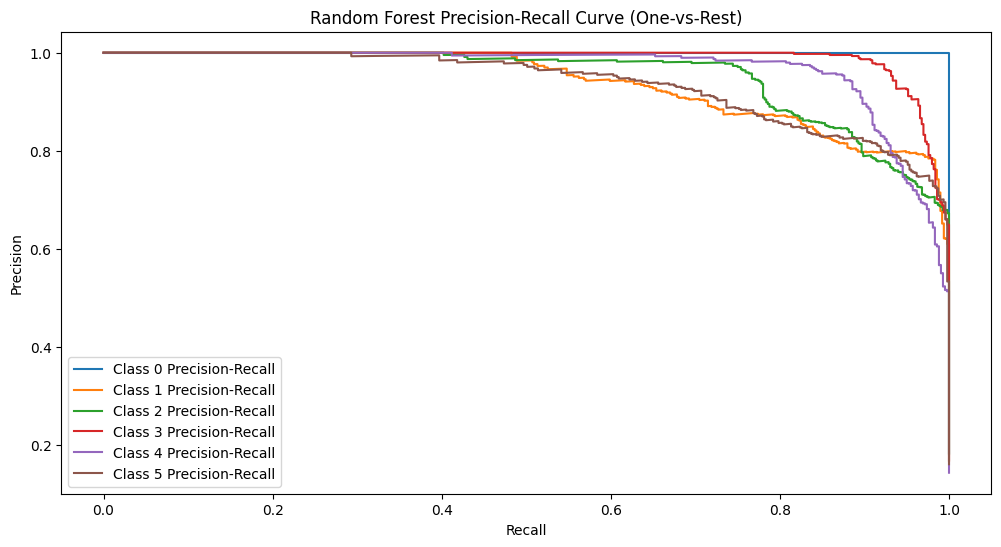

Evaluating Logistic Regression model...
Logistic Regression - Train Accuracy: 0.9906
Logistic Regression - Test Accuracy: 0.9545


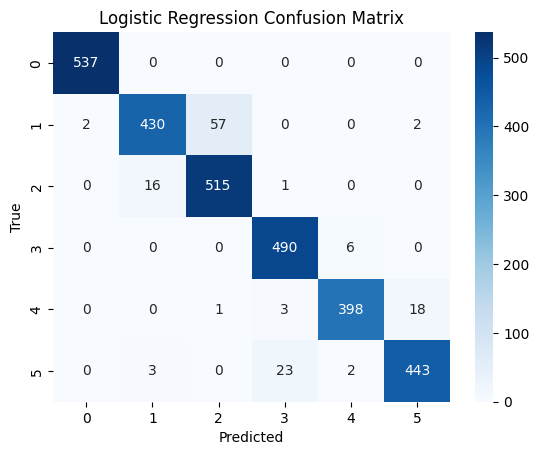

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.88      0.91       491
           2       0.90      0.97      0.93       532
           3       0.95      0.99      0.97       496
           4       0.98      0.95      0.96       420
           5       0.96      0.94      0.95       471

    accuracy                           0.95      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.96      0.95      0.95      2947



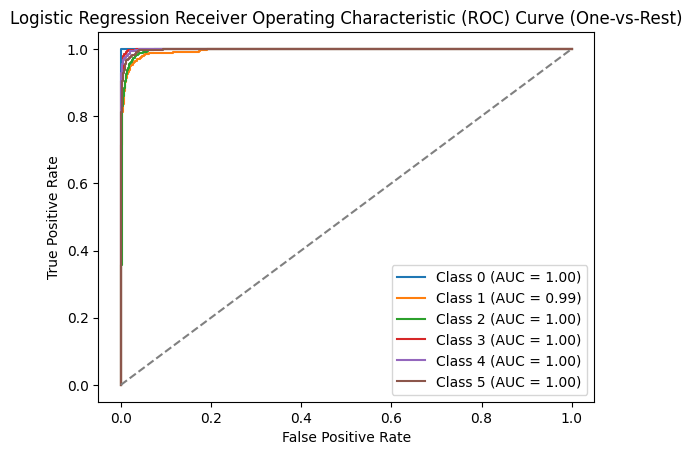

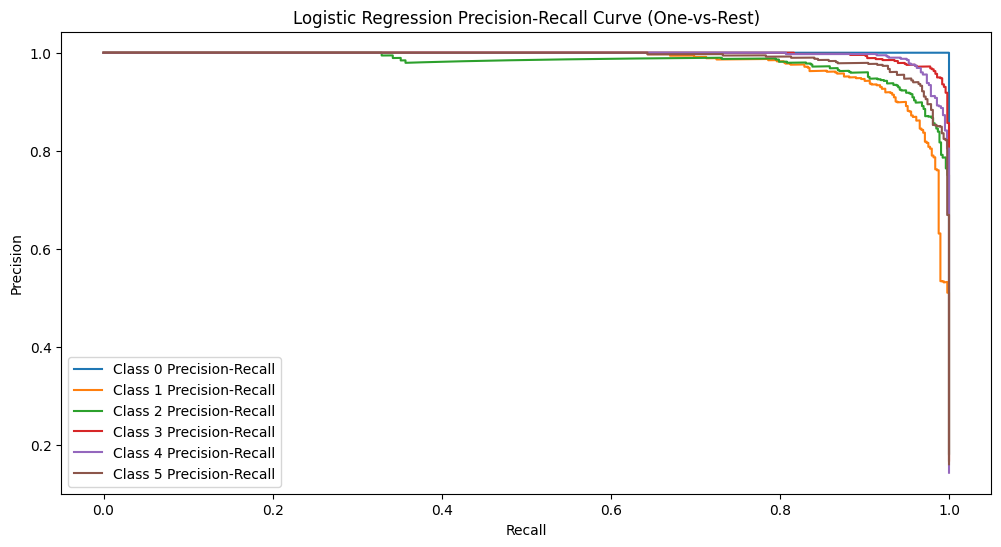

Evaluating ANN model...
ANN - Train Accuracy: 1.0000
ANN - Test Accuracy: 0.9508


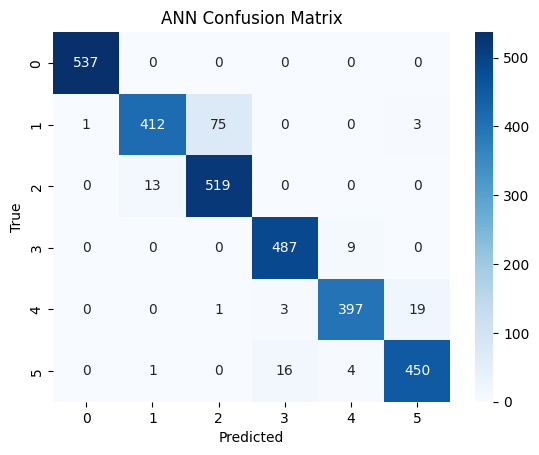

ANN - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.97      0.84      0.90       491
           2       0.87      0.98      0.92       532
           3       0.96      0.98      0.97       496
           4       0.97      0.95      0.96       420
           5       0.95      0.96      0.95       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



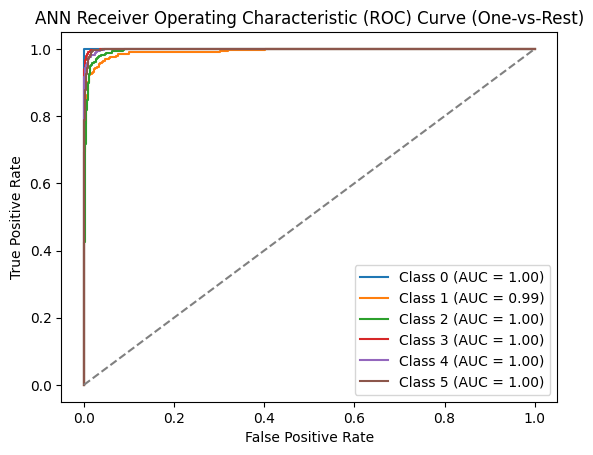

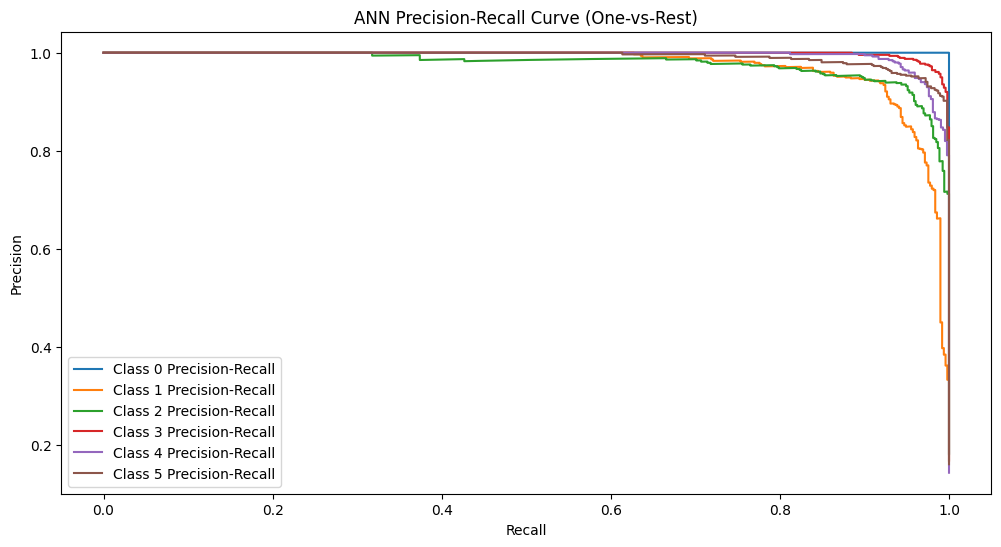

Evaluating XGBoost model...
XGBoost - Train Accuracy: 1.0000
XGBoost - Test Accuracy: 0.9233


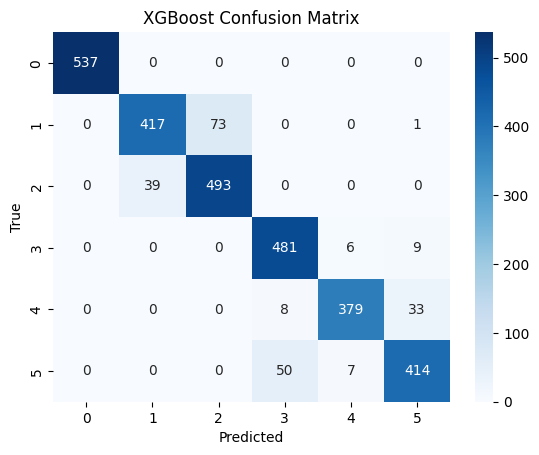

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.91      0.85      0.88       491
           2       0.87      0.93      0.90       532
           3       0.89      0.97      0.93       496
           4       0.97      0.90      0.93       420
           5       0.91      0.88      0.89       471

    accuracy                           0.92      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



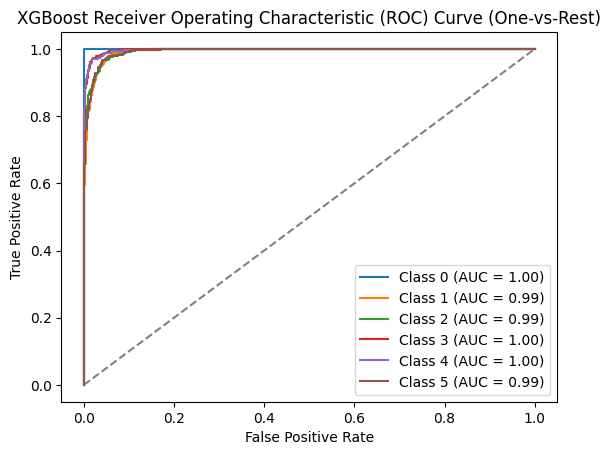

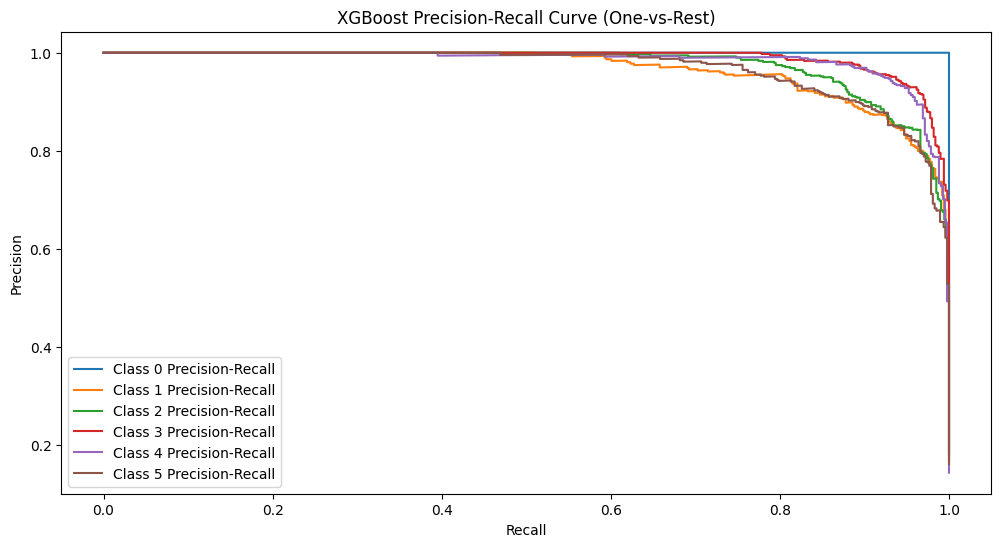

Evaluating LightGBM model...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM - Train Accuracy: 1.0000
LightGBM - Test Accuracy: 0.9260


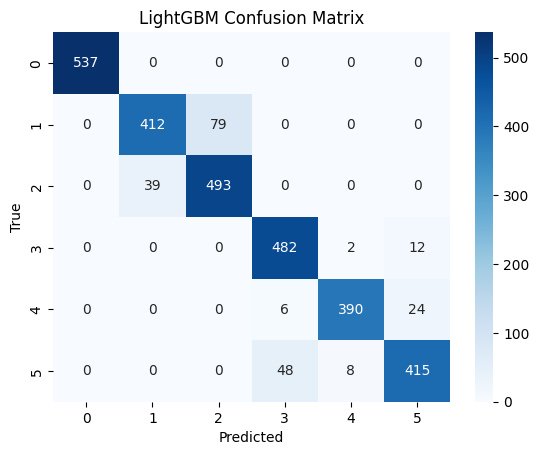

LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.91      0.84      0.87       491
           2       0.86      0.93      0.89       532
           3       0.90      0.97      0.93       496
           4       0.97      0.93      0.95       420
           5       0.92      0.88      0.90       471

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947



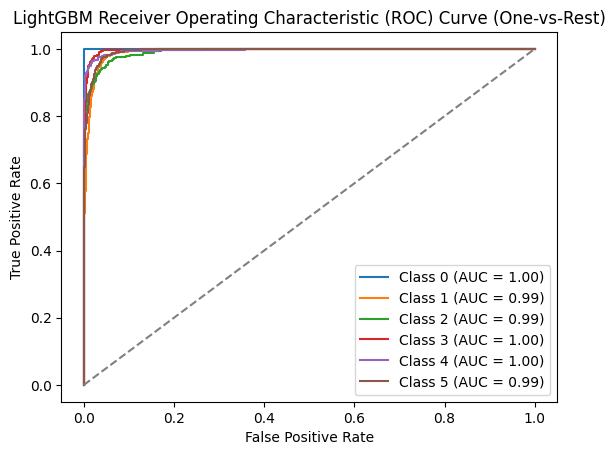

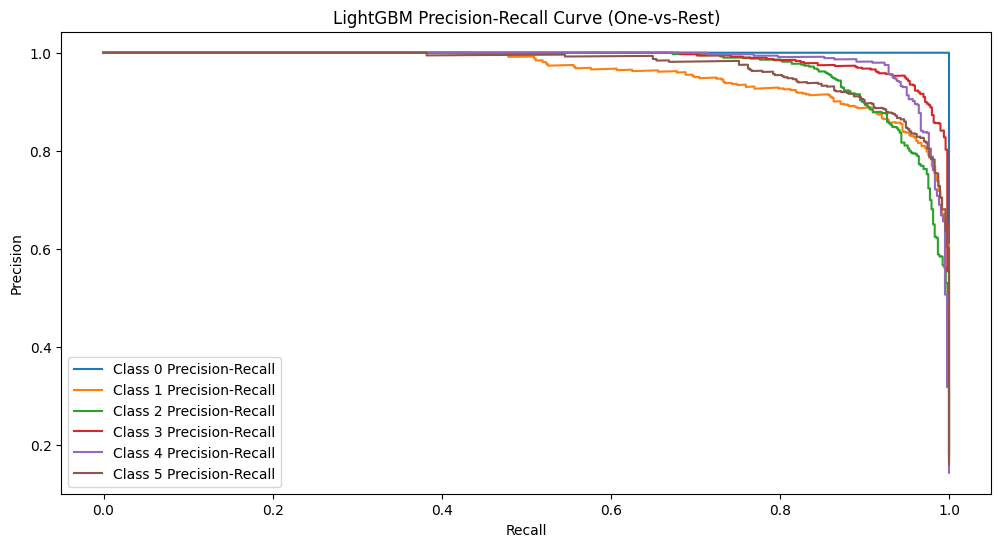

Evaluating Voting Classifier model...
Voting Classifier - Train Accuracy: 0.9981
Voting Classifier - Test Accuracy: 0.9562


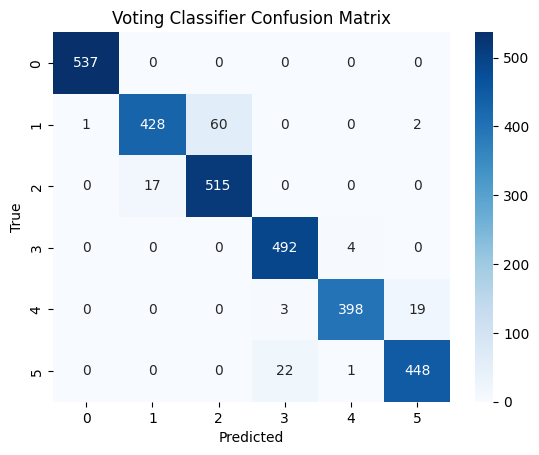

Voting Classifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.87      0.91       491
           2       0.90      0.97      0.93       532
           3       0.95      0.99      0.97       496
           4       0.99      0.95      0.97       420
           5       0.96      0.95      0.95       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



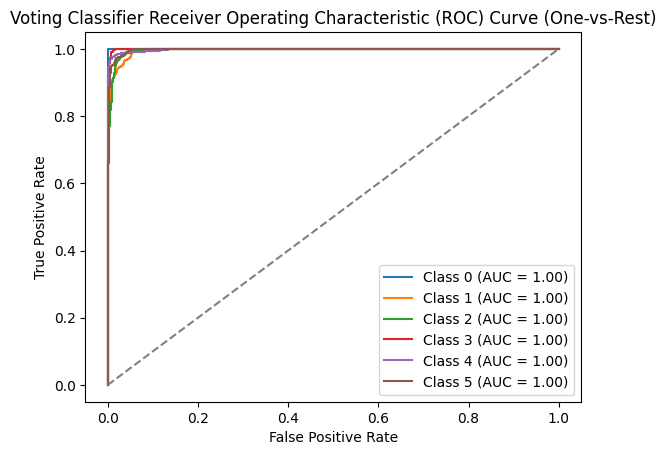

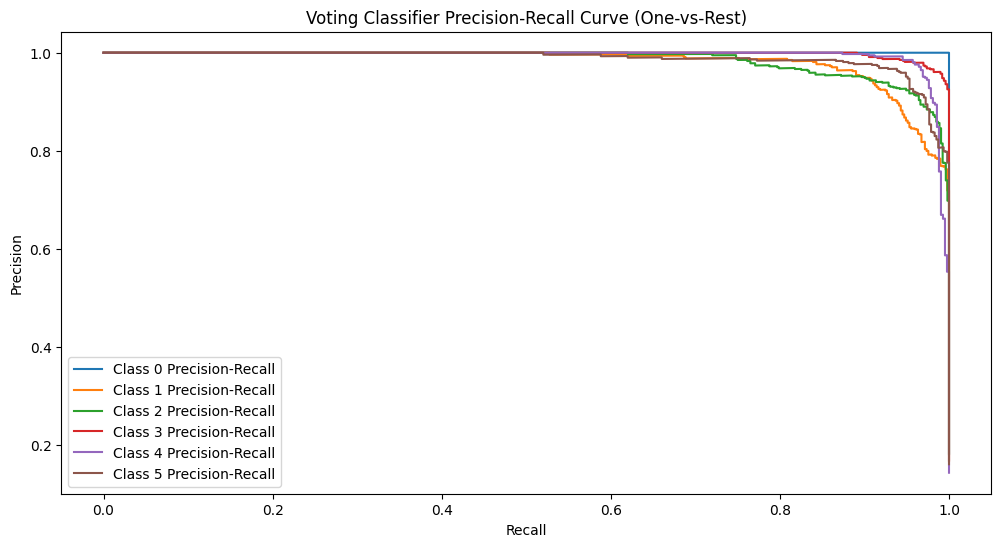

Evaluating Stacking Classifier model...
Stacking Classifier - Train Accuracy: 0.9990
Stacking Classifier - Test Accuracy: 0.9579


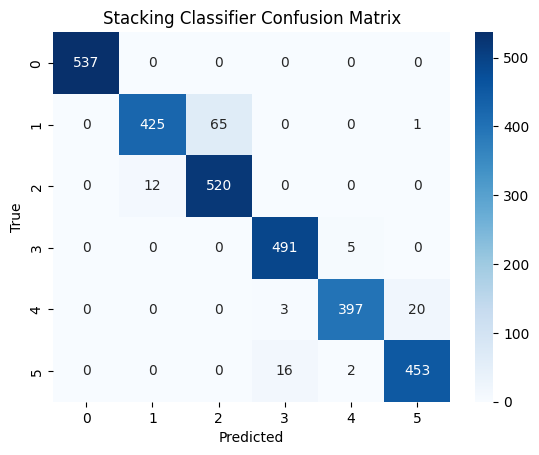

Stacking Classifier - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.97      0.87      0.92       491
           2       0.89      0.98      0.93       532
           3       0.96      0.99      0.98       496
           4       0.98      0.95      0.96       420
           5       0.96      0.96      0.96       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



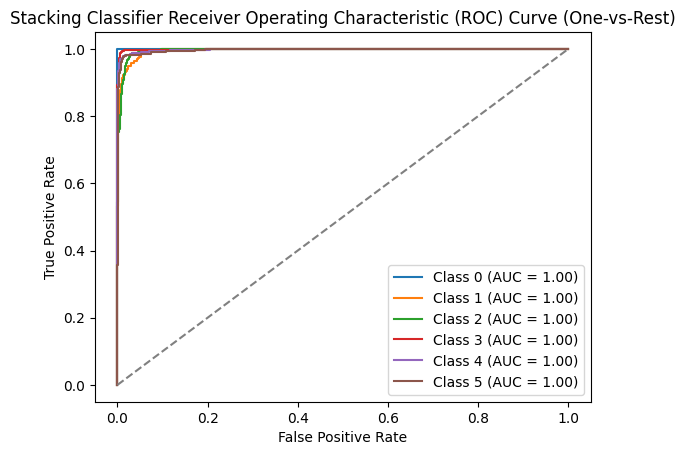

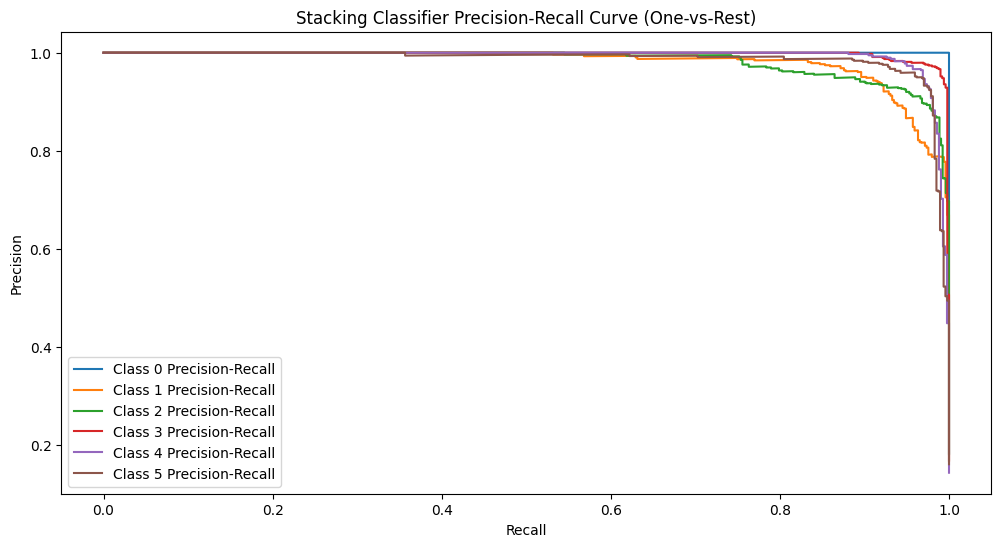

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import label_binarize

# Evaluate models and plot AUC-ROC, Precision-Recall, and Confusion Matrix
models_to_evaluate = {
    'SVM (Custom Kernel)': svm_model_custom_kernel_precomputed,
    'SVM (RBF Kernel)': svm_model_rbf,
    'SVM (Linear Kernel)': svm_model_linear,
    'SVM (Polynomial Kernel)': svm_model_poly,
    'Random Forest': rf_model,
    'Logistic Regression': lr_model,
    'ANN': ann_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model,
    'Voting Classifier': voting_model,
    'Stacking Classifier': stacking_model
}

for model_name, model in models_to_evaluate.items():
    print(f"Evaluating {model_name} model...")

    # Get predictions
    if model_name == 'SVM (Custom Kernel)':
        y_train_pred = model.predict(K_train)
        y_test_pred = model.predict(K_test)
        y_score = model.predict_proba(K_test)  # Get probabilities for AUC/PR
    elif model_name == 'Voting Classifier' or model_name == 'Stacking Classifier':
        y_train_pred = model.predict(X_train_selected)
        y_test_pred = model.predict(X_test_selected)
        y_score = model.predict_proba(X_test_selected) # Get probabilities for AUC/PR
    else:
        y_train_pred = model.predict(X_train_selected)
        y_test_pred = model.predict(X_test_selected)
        y_score = model.predict_proba(X_test_selected)  # Get probabilities for AUC/PR


    # Calculate Accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"{model_name} - Train Accuracy: {train_accuracy:.4f}")
    print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print(f"{model_name} - Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Binarize the output for AUC and Precision-Recall curves
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]

    # AUC-ROC curve for each class (One-vs-Rest)
    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # diagonal line for random performance
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall curve for each class (One-vs-Rest)
    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f'Class {i} Precision-Recall')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve (One-vs-Rest)')
    plt.legend(loc="lower left")
    plt.show()

# **7. SHAP for Custom Kernel SVM**

In [ ]:
# Using KernelExplainer for Custom Kernel SVM
# KernelExplainer requires a background dataset and a prediction function
# We'll use a small subset of the training data as the background dataset for efficiency
import shap
# Pass the background data directly as a NumPy array or pandas DataFrame
X_train_background = X_train_selected[np.random.choice(X_train_selected.shape[0], 100, replace=False)]

# Define a prediction function for the custom kernel SVM
# This function takes the original feature data (X) and returns the model's output
def custom_svm_predict_proba(X):
    # Compute the kernel matrix between the input data X and the training data used for fitting
    K_predict = custom_kernel(X, X_train_selected, gamma=best_gamma)
    # Use the trained SVM model to predict probabilities
    return svm_model_custom_kernel_precomputed.predict_proba(K_predict)

print("\n--- SHAP Summary Plot for Custom Kernel SVM ---")

# Initialize KernelExplainer with the prediction function and background dataset
explainer_svm_custom = shap.KernelExplainer(custom_svm_predict_proba, X_train_background)

# Compute SHAP values for a subset of the test data
# Using a smaller subset for demonstration due to KernelExplainer's computational cost
shap_values_svm_custom = explainer_svm_custom.shap_values(X_test_selected[:100])

# Plot SHAP summary for Custom Kernel SVM
shap.bar_plot(shap_values_svm_custom[0], feature_names=selected_feature_names)


--- SHAP Summary Plot for Custom Kernel SVM ---


  0%|          | 0/100 [00:00<?, ?it/s]